In [ ]:
!pip install tensorflow==2.0.0.alpha0

In [ ]:
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [ ]:
import tensorflow.compat.v1 as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [ ]:
!git clone https://github.com/MLWhiz/object_detection

Cloning into 'object_detection'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 114 (delta 10), reused 111 (delta 7), pack-reused 0
Receiving objects: 100% (114/114), 40.79 MiB | 21.29 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 9.42 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [ ]:
%cd Mask_RCNN
!pip install -r requirements.txt

/content/Mask_RCNN
     |████████████████████████████████| 204kB 8.4MB/s 
     |████████████████████████████████| 163kB 9.4MB/s 


In [ ]:
cp -r /content/object_detection/guns_and_swords/* /content/Mask_RCNN/samples

In [ ]:
from random import random
import os
from glob import glob
import json

In [ ]:
# Path to your images
image_paths = glob("/content/object_detection/data/*")
#Path to your annotations from VIA tool
annotation_file = '/content/object_detection/via_region_data.json'
#clean up the annotations a little
annotations = json.load(open(annotation_file))
cleaned_annotations = {}
for k,v in annotations['_via_img_metadata'].items():
    cleaned_annotations[v['filename']] = v

In [ ]:
annotations = json.load(open(annotation_file))
cleaned_annotations = {}
for k,v in annotations['_via_img_metadata'].items():
    cleaned_annotations[v['filename']] = v
# create train and validation directories
! mkdir procdata
! mkdir procdata/val
! mkdir procdata/train
train_annotations = {}
valid_annotations = {}
# 20% of images in validation folder
for img in image_paths:
    # Image goes to Validation folder
    if random()<0.2:
        os.system("cp "+ img + " procdata/val/")
        img = img.split("/")[-1]
        valid_annotations[img] = cleaned_annotations[img]
    else:
        os.system("cp "+ img + " procdata/train/")
        img = img.split("/")[-1]
        train_annotations[img] = cleaned_annotations[img]
# put different annotations in different folders
with open('procdata/val/via_region_data.json', 'w') as fp:
    json.dump(valid_annotations, fp)
with open('procdata/train/via_region_data.json', 'w') as fp:
    json.dump(train_annotations, fp)

In [ ]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("content/")

In [ ]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from object_detection.guns_and_swords import gns
%matplotlib inline

In [ ]:
config = gns.gnsConfig()
GNS_DIR = "/content/Mask_RCNN/procdata"

In [ ]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = gns.gnsDataset()
dataset.load_gns(GNS_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 63
Class Count: 3
  0. BG                                                
  1. sword                                             
  2. gun                                               


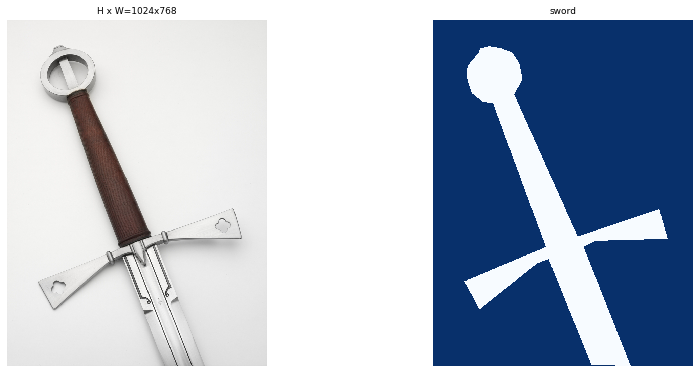

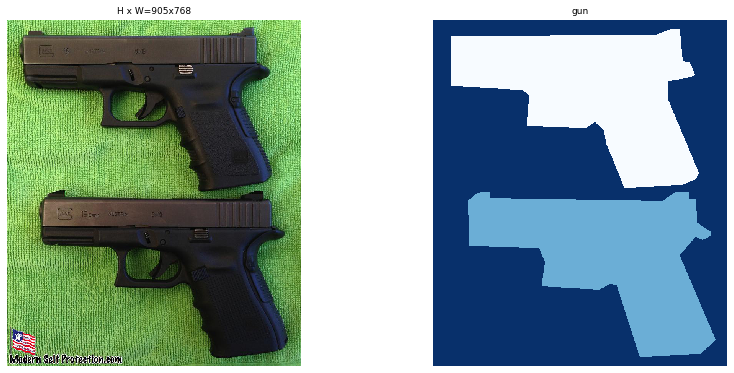

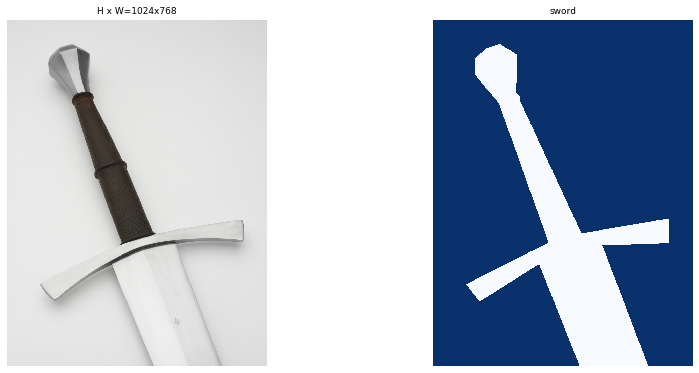

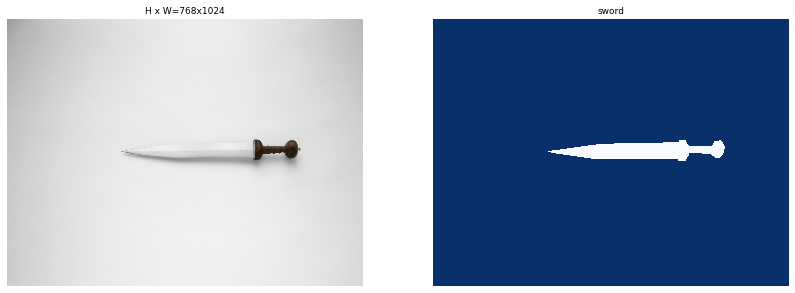

In [ ]:

# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    class_ids = [int(x) for x in class_ids]
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names,limit=1)

image_id  61 /content/Mask_RCNN/procdata/train/1f8044ec515fcf82.jpg
image                    shape: (680, 1024, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (680, 1024, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    2.00000  max:    2.00000  int64
bbox                     shape: (1, 4)                min:   50.00000  max:  913.00000  int32


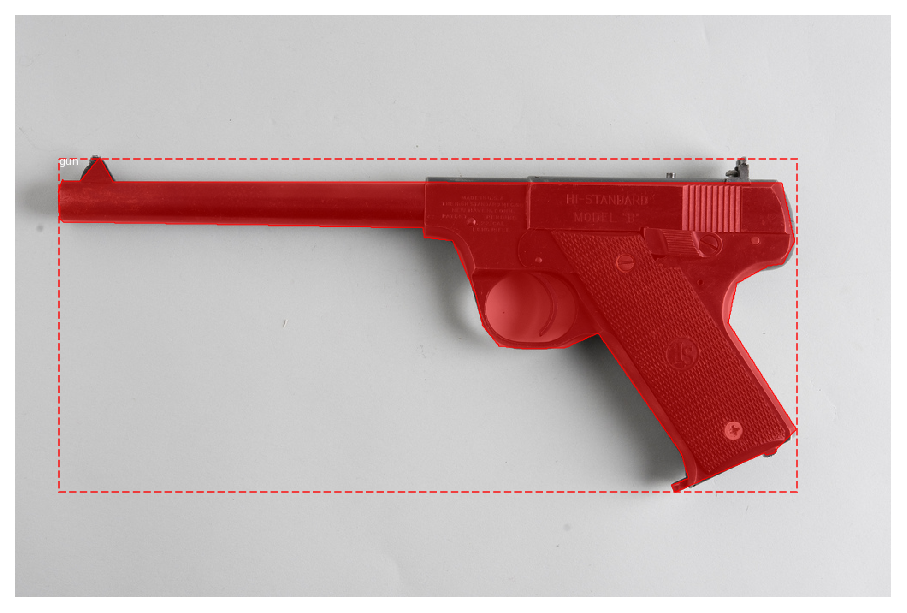

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id  39 /content/Mask_RCNN/procdata/train/2f06c2edea7bf0b5.jpg
image                    shape: (768, 1024, 3)        min:   13.00000  max:  255.00000  uint8
mask                     shape: (768, 1024, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int64
bbox                     shape: (1, 4)                min:   88.00000  max:  908.00000  int32


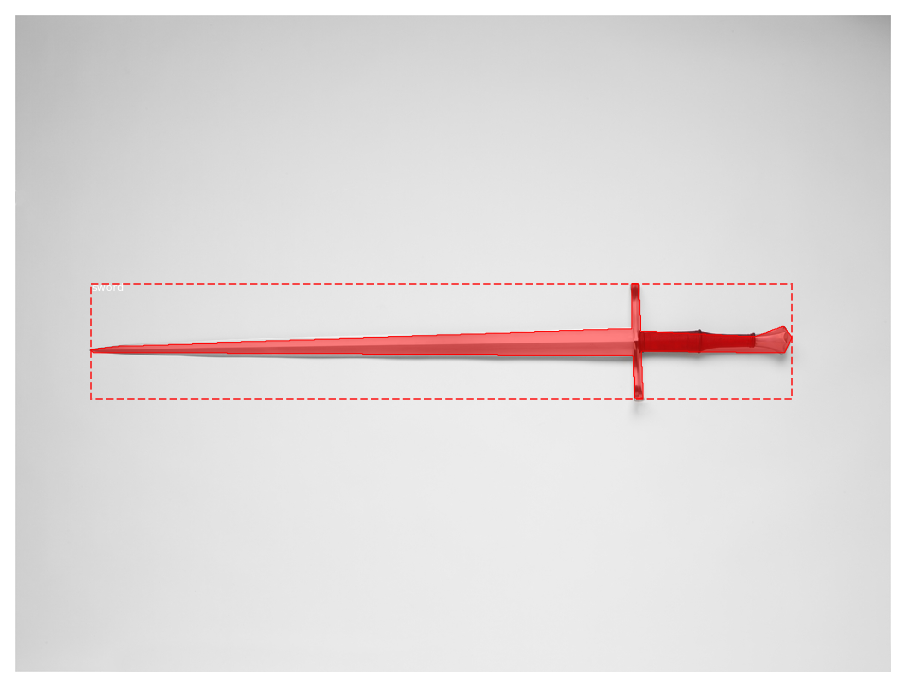

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id  12 /content/Mask_RCNN/procdata/train/5bc0e450b2e93f6a.jpg
image                    shape: (768, 1024, 3)        min:    7.00000  max:  235.00000  uint8
mask                     shape: (768, 1024, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    2.00000  max:    2.00000  int64
bbox                     shape: (1, 4)                min:  271.00000  max:  928.00000  int32


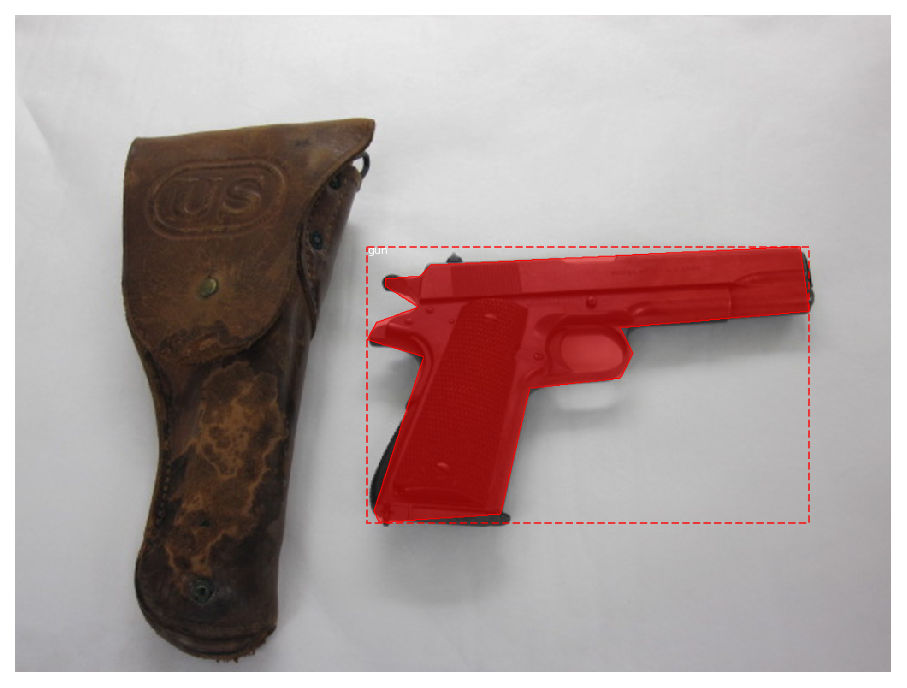

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id  21 /content/Mask_RCNN/procdata/train/5a2974d792a69b5e.jpg
image                    shape: (819, 1024, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (819, 1024, 2)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    2.00000  max:    2.00000  int64
bbox                     shape: (2, 4)                min:   30.00000  max:  864.00000  int32


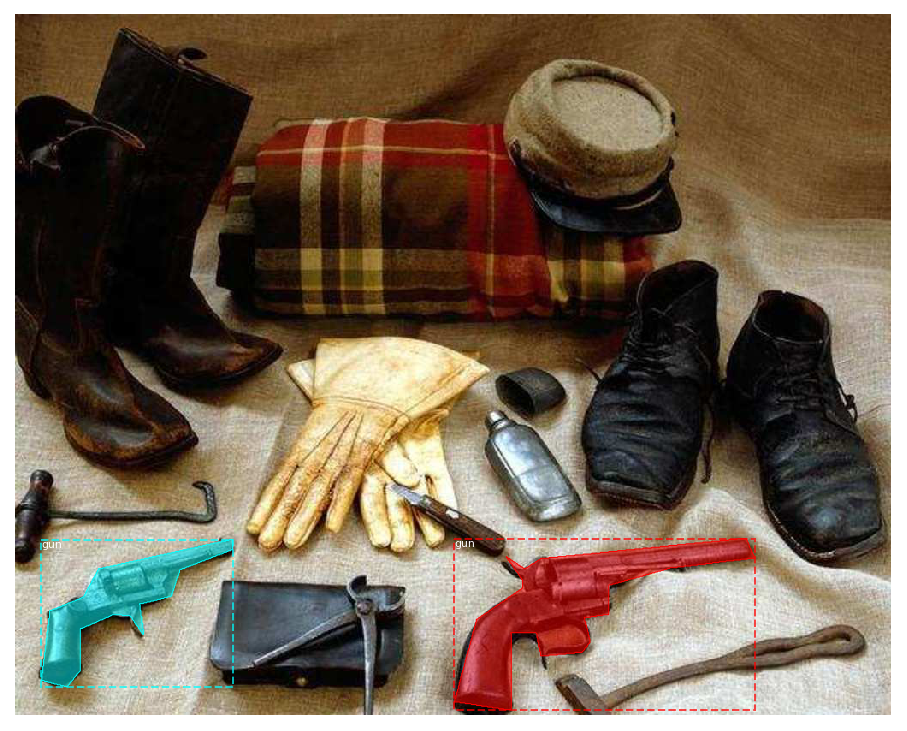

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id  30 /content/Mask_RCNN/procdata/train/1d6c5b47ac435d2d.jpg
image                    shape: (632, 1024, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (632, 1024, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    2.00000  max:    2.00000  int64
bbox                     shape: (1, 4)                min:  101.00000  max:  909.00000  int32


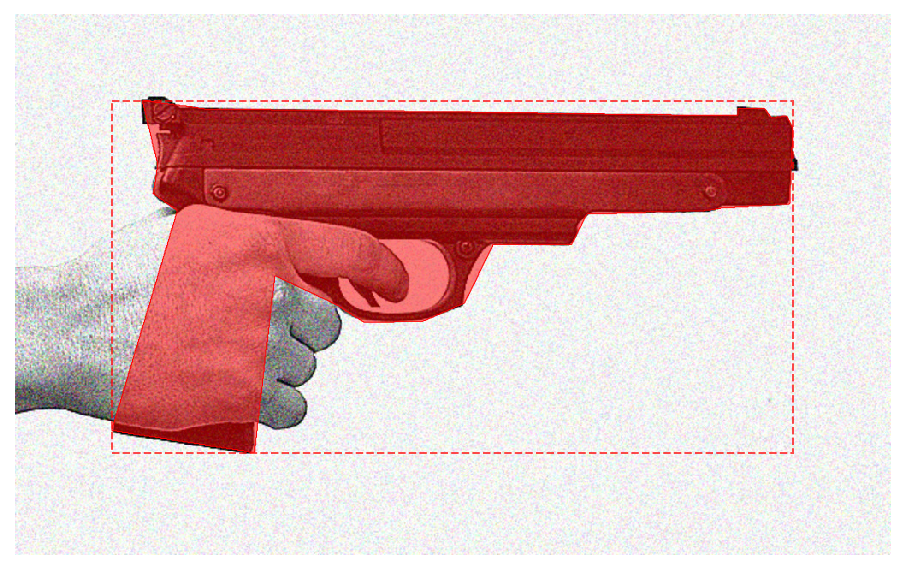

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn

In [ ]:
# Train a new model starting from pre-trained COCO weights
 !python3 /content/object_detection/guns_and_swords/gns.py train --dataset /content/Mask_RCNN/images --weights /content/mask_rcnn_balloon.h5